In [2]:
import os
import sys
sys.path.append('/Users/aghavamp/Desktop/Projects')
sys.path.append('/Users/aghavamp/Desktop/Projects/bimanual_wrist')

from pathlib import Path
import glob
import getpass
import importlib
import tqdm

import numpy as np
import pandas as pd
import scipy.io as sio
import scipy.stats as stats

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.cm import ScalarMappable
import matplotlib.cm as cm
import matplotlib.colors as mcolors

import utils
importlib.reload(utils)

# SET PATHS:
baseDir = os.path.join('/Users', getpass.getuser(), 'Desktop', 'Projects', 'bimanual_wrist')
fMRI_behavDir = os.path.join(baseDir,'data','fMRI','behavioural')
train_behavDir = os.path.join(baseDir,'data','training')
anaDir = os.path.join(baseDir,'analysis')
figDir = os.path.join(baseDir,'figures')
# figDir = os.path.join(f'/Users/{getpass.getuser()}/Library/Mobile Documents/com~apple~CloudDocs/Projects/bimanual')

path = {'baseDir': baseDir,
        'fMRI_behavDir': fMRI_behavDir,
        'train_behavDir': train_behavDir,
        'anaDir': anaDir}



The distance from the center of the home to the center of target is 3.5cm

# success rate

In [ ]:
sn_bad = [102, 103]
D = pd.read_csv(os.path.join(anaDir, f'bmw_all.csv'))
D = D[(~D['sn'].isin(sn_bad)) & (D['fMRI_sess']==1)].reset_index(drop=True)


D_uni = D[D['Uni_or_Bi']==1].reset_index(drop=True)
D_bi = D[D['Uni_or_Bi']==0].reset_index(drop=True)

# success rate for each per subject:
succ = {'sn': [], 'unimanual': [], 'bimanual': []}
for sn in D['sn'].unique():
    D_sn = D[D['sn']==sn]
    D_sn_uni = D_sn[D_sn['Uni_or_Bi']==0]
    D_sn_bi = D_sn[D_sn['Uni_or_Bi']==1]
    
    uni_succ = D_sn_uni['GoodMovement'].sum() / D_sn_uni.shape[0]
    bi_succ = D_sn_bi['GoodMovement'].sum() / D_sn_bi.shape[0]
    
    succ['sn'].append(sn)
    succ['unimanual'].append(uni_succ)
    succ['bimanual'].append(bi_succ)

succ = pd.DataFrame(succ)
print(f'unimanual: {succ["unimanual"].mean():.3f} +/- {stats.sem(succ["unimanual"]):.3f}')
print(f'bimanual: {succ["bimanual"].mean():.3f} +/- {stats.sem(succ["bimanual"]):.3f}')




unimanual: 0.967 +/- 0.008
bimanual: 0.836 +/- 0.023


# Average trajectories

In [26]:
sn_list = [101, 104, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115]
# sn_list = [101]
D = pd.read_csv(os.path.join(anaDir, f's{101}_scan.csv'))
conds = D.cond_name.unique()

avg_traj = {'sn': [], 'cond': [], 'avg_x_l': [], 'avg_y_l': [], 'avg_x_r': [], 'avg_y_r': []}
for cond in conds:
    for sn in sn_list:
        D = pd.read_csv(os.path.join(anaDir, f's{sn}_scan.csv'))
        D = D[D.GoodMovement == 1]
        D_mov = pd.read_csv(os.path.join(anaDir, f's{sn}_scan_mov.csv'))

        left_conds = [tmp for tmp in conds if 'left_' in tmp]
        right_conds = [tmp for tmp in conds if 'right_' in tmp]
    
        BNs = D.BN[D.cond_name==cond].values.flatten()
        TNs = D.TN[D.cond_name==cond].values.flatten()
        
        # average the trajectories across all trials of the same condition:
        n_trials = len(BNs)
        subj_avg = {'x_l': np.full((n_trials, 10000), np.nan), 
                    'y_l': np.full((n_trials, 10000), np.nan), 
                    'x_r': np.full((n_trials, 10000), np.nan), 
                    'y_r': np.full((n_trials, 10000), np.nan)}
        for i in range(len(BNs)):
            BN = BNs[i]
            TN = TNs[i]
            RT = D.RT[(D.BN==BN) & (D.TN==TN)].values[0]
            idx_gocue = D.idx_gocue[(D.BN==BN) & (D.TN==TN)].values[0]
            idx_endReach = D.idx_endReach[(D.BN==BN) & (D.TN==TN)].values[0]
            
            t1 = idx_gocue
            t2 = int(np.median(D.idx_endReach.values))
            
            # kinematic traces:
            trial_mov = D_mov[(D_mov.BN==BN) & (D_mov.TN==TN)]
            radius_l = trial_mov['mov_5'].values.flatten()[t1:t2]
            radius_r = trial_mov['mov_6'].values.flatten()[t1:t2]
            angle_l = trial_mov['mov_7'].values.flatten()[t1:t2]
            angle_r = trial_mov['mov_8'].values.flatten()[t1:t2]
            
            radius = 5
            x_offset = radius + 2
            y_offset = 0
            x_l = radius_l * np.cos(np.deg2rad(angle_l)) - x_offset
            y_l = radius_l * np.sin(np.deg2rad(angle_l)) + y_offset
            x_r = radius_r * np.cos(np.deg2rad(angle_r)) + x_offset
            y_r = radius_r * np.sin(np.deg2rad(angle_r)) + y_offset

            subj_avg['x_l'][i,:len(x_l)] = x_l
            subj_avg['y_l'][i,:len(y_l)] = y_l
            subj_avg['x_r'][i,:len(x_r)] = x_r
            subj_avg['y_r'][i,:len(y_r)] = y_r
        
        avg_x_l = np.nanmean(np.array(subj_avg['x_l']), axis=0)
        avg_y_l = np.nanmean(np.array(subj_avg['y_l']), axis=0)
        avg_x_r = np.nanmean(np.array(subj_avg['x_r']), axis=0)
        avg_y_r = np.nanmean(np.array(subj_avg['y_r']), axis=0)

        # remove nans at the end:
        valid_idx = np.where(~np.isnan(avg_x_l))[0]
        avg_x_l = avg_x_l[valid_idx]
        avg_y_l = avg_y_l[valid_idx]
        avg_x_r = avg_x_r[valid_idx]
        avg_y_r = avg_y_r[valid_idx]

        avg_traj['sn'].append(sn)
        avg_traj['cond'].append(cond)
        avg_traj['avg_x_l'].append(avg_x_l)
        avg_traj['avg_y_l'].append(avg_y_l)
        avg_traj['avg_x_r'].append(avg_x_r)
        avg_traj['avg_y_r'].append(avg_y_r)
    
df = pd.DataFrame(avg_traj)
df.to_pickle(os.path.join(anaDir, 'avg_traj.pkl'))




/var/folders/sc/kmc7_9gn2hqd_lrnhdt_2s580000gn/T/ipykernel_42103/2855738185.py:55: RuntimeWarning: Mean of empty slice
  avg_x_l = np.nanmean(np.array(subj_avg['x_l']), axis=0)
/var/folders/sc/kmc7_9gn2hqd_lrnhdt_2s580000gn/T/ipykernel_42103/2855738185.py:56: RuntimeWarning: Mean of empty slice
  avg_y_l = np.nanmean(np.array(subj_avg['y_l']), axis=0)
/var/folders/sc/kmc7_9gn2hqd_lrnhdt_2s580000gn/T/ipykernel_42103/2855738185.py:57: RuntimeWarning: Mean of empty slice
  avg_x_r = np.nanmean(np.array(subj_avg['x_r']), axis=0)
/var/folders/sc/kmc7_9gn2hqd_lrnhdt_2s580000gn/T/ipykernel_42103/2855738185.py:58: RuntimeWarning: Mean of empty slice
  avg_y_r = np.nanmean(np.array(subj_avg['y_r']), axis=0)
/var/folders/sc/kmc7_9gn2hqd_lrnhdt_2s580000gn/T/ipykernel_42103/2855738185.py:55: RuntimeWarning: Mean of empty slice
  avg_x_l = np.nanmean(np.array(subj_avg['x_l']), axis=0)
/var/folders/sc/kmc7_9gn2hqd_lrnhdt_2s580000gn/T/ipykernel_42103/2855738185.py:56: RuntimeWarning: Mean of empty sl

,sn,cond,avg_x_l,avg_y_l,avg_x_r,avg_y_r
0,101,left_240,"[-6.892207278267185, -6.892067321182256, -6.89...","[0.03608876206366121, 0.03632460804190944, 0.0...","[6.801803285480684, 6.801493760304283, 6.80173...","[-0.11596022038176103, -0.11645788333991941, -..."
1,104,left_240,"[-7.043397071499756, -7.043240592065681, -7.04...","[-0.03657409678789175, -0.0362356624211004, -0...","[6.989696871839409, 6.989694757897395, 6.98990...","[-0.05630111684652976, -0.056440402383318856, ..."
2,106,left_240,"[-7.08470201916845, -7.084549344943162, -7.084...","[-0.05178855479207381, -0.051840582034604635, ...","[7.178136735482354, 7.180003520274399, 7.17973...","[-0.1964683361537905, -0.19613807303042344, -0..."
3,107,left_240,"[-7.127297809033109, -7.127475039572827, -7.12...","[-0.14683823394471976, -0.1487145166309442, -0...","[7.013389470699574, 7.013300826046884, 7.01331...","[-0.16242347040188848, -0.16199176510255756, -..."
4,108,left_240,"[-7.013399938705243, -7.013057761692248, -7.01...","[-0.04194814930612416, -0.04158695469541207, -...","[6.919975974037317, 6.9201555046007055, 6.9203...","[-0.07744893378100969, -0.07757611074866873, -..."
...,...,...,...,...,...,...
571,111,bimanual_120_240,"[-6.880322426817164, -6.880596407743289, -6.88...","[0.039945472686661154, 0.040552888579989496, 0...","[7.133398347598386, 7.133556689484372, 7.13287...","[-0.03603502734260956, -0.0365210562473955, -0..."
572,112,bimanual_120_240,"[-6.979799437750504, -6.980236382896829, -6.98...","[-0.1723208293548233, -0.17172654747280197, -0...","[7.003682580101179, 7.003836488890818, 7.00356...","[-0.11164108127848514, -0.11152336034715539, -..."
573,113,bimanual_120_240,"[-6.94904858101751, -6.949274657816084, -6.949...","[0.10667052831823096, 0.10734498983981881, 0.1...","[6.9692748469342, 6.968954552560487, 6.9688308...","[0.03182644258263151, 0.03175069864756183, 0.0..."
574,114,bimanual_120_240,"[-6.950168236361125, -6.950707655665739, -6.95...","[-0.08592418204440747, -0.08605905109375551, -...","[6.939473851218944, 6.939422757362866, 6.93948...","[-0.03926270962498931, -0.03936438089057105, -..."


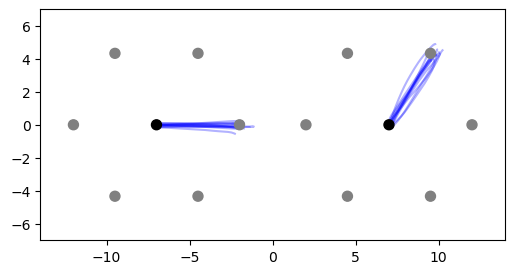

In [27]:
df = pd.read_pickle(os.path.join(anaDir, 'avg_traj.pkl'))
conds = df.cond.unique()

for cond in conds:
    df_cond = df[(df.cond==cond)]
    fix, ax = plt.subplots(figsize=(6, 3))
    for i, row in df_cond.iterrows():
        plt.plot(row['avg_x_l'], row['avg_y_l'], color='blue', alpha=0.3, lw=1.5)
        plt.plot(row['avg_x_r'], row['avg_y_r'], color='blue', alpha=0.3, lw=1.5)
    utils.please.draw_board(ax=ax, radius=5, zorder=999)
    ax.set_xlim(-14, 14)
    ax.set_ylim(-7, 7)
    # save figure:
    plt.savefig(os.path.join(figDir, 'reach_trajectories', f'{cond}.pdf'), bbox_inches="tight")
    if cond == 'bimanual_0_60': # show for one of the conditions as an example
        plt.show()
    else:
        plt.close()
    # plt.show()




# Bimanual vs Unimanual Equivalent Movement

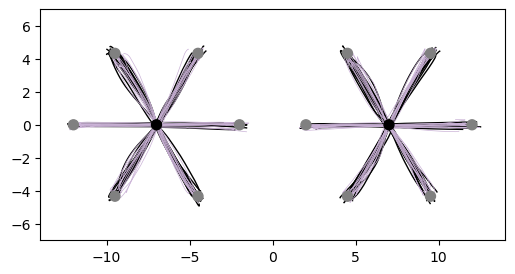

In [28]:
df = pd.read_pickle(os.path.join(anaDir, 'avg_traj.pkl'))
conds = df.cond.unique()
uni_conds = ['left_0', 'left_60', 'left_120', 'left_180', 'left_240', 'left_300',
             'right_0', 'right_60', 'right_120', 'right_180', 'right_240', 'right_300']

def mean_of_arrays(series):
    return np.mean(np.stack(series.values), axis=0)

# pick colors:
color_uni = cm.Paired(8)
color_bi = '#000000'

for cond in uni_conds:
    df_uni = df[(df.cond==cond)]
    cond_angle = cond.split('_')[1]
    if 'left' in cond:
        # select bimanual conditoins in form of 'bimanual_cond.split('_')[1]_xx'
        df_bimanual = df[df.cond.str.contains('bimanual') & df.cond.str.startswith(f'bimanual_{cond_angle}')]
        # average the trajectories within subjects, e.g., bimanual_0_0, bimanual_0_60, bimanual_0_120, ...:
        agg_funcs = {'avg_x_l': mean_of_arrays, 'avg_y_l': mean_of_arrays, 'avg_x_r': mean_of_arrays, 'avg_y_r': mean_of_arrays}
        df_bimanual = df_bimanual.groupby('sn').agg(agg_funcs).reset_index()
    else:
        df_bimanual = df[df.cond.str.contains('bimanual') & df.cond.str.endswith(f'_{cond_angle}')]
        agg_funcs = {'avg_x_l': mean_of_arrays, 'avg_y_l': mean_of_arrays, 'avg_x_r': mean_of_arrays, 'avg_y_r': mean_of_arrays}
        df_bimanual = df_bimanual.groupby('sn').agg(agg_funcs).reset_index()

    fix, ax = plt.subplots(figsize=(6, 3))
    for i, row in df_bimanual.iterrows():
        # plot bimanual trajectories:
        if 'left' in cond:
            plt.plot(row['avg_x_l'], row['avg_y_l'], color=color_bi, alpha=0.3, lw=1)
        elif 'right' in cond:
            plt.plot(row['avg_x_r'], row['avg_y_r'], color=color_bi, alpha=0.3, lw=1)

    for i, row in df_uni.iterrows():
        # plot unimanual trajectories:
        plt.plot(row['avg_x_l'], row['avg_y_l'], color=color_uni, alpha=0.3, lw=1)
        plt.plot(row['avg_x_r'], row['avg_y_r'], color=color_uni, alpha=0.3, lw=1)
    
    utils.please.draw_board(ax=ax, radius=5, zorder=999)
    ax.set_xlim(-14, 14)
    ax.set_ylim(-7, 7)
    # save figure:
    plt.savefig(os.path.join(figDir, 'reach_trajectories', f'{cond}_vs_bimanual.pdf'), bbox_inches="tight")
    plt.close()


fix, ax = plt.subplots(figsize=(6, 3))
for cond in uni_conds:
    df_uni = df[(df.cond==cond)]
    cond_angle = cond.split('_')[1]
    if 'left' in cond:
        # select bimanual conditoins in form of 'bimanual_cond.split('_')[1]_xx'
        df_bimanual = df[df.cond.str.contains('bimanual') & df.cond.str.startswith(f'bimanual_{cond_angle}')]
        # average the trajectories within subjects, e.g., bimanual_0_0, bimanual_0_60, bimanual_0_120, ...:
        agg_funcs = {'avg_x_l': mean_of_arrays, 'avg_y_l': mean_of_arrays, 'avg_x_r': mean_of_arrays, 'avg_y_r': mean_of_arrays}
        df_bimanual = df_bimanual.groupby('sn').agg(agg_funcs).reset_index()
    else:
        df_bimanual = df[df.cond.str.contains('bimanual') & df.cond.str.endswith(f'_{cond_angle}')]
        agg_funcs = {'avg_x_l': mean_of_arrays, 'avg_y_l': mean_of_arrays, 'avg_x_r': mean_of_arrays, 'avg_y_r': mean_of_arrays}
        df_bimanual = df_bimanual.groupby('sn').agg(agg_funcs).reset_index()

    for i, row in df_bimanual.iterrows():
        # plot bimanual trajectories:
        if 'left' in cond:
            plt.plot(row['avg_x_l'], row['avg_y_l'], color=color_bi, alpha=1, lw=1)
        elif 'right' in cond:
            plt.plot(row['avg_x_r'], row['avg_y_r'], color=color_bi, alpha=1, lw=1)

    for i, row in df_uni.iterrows():
        # plot unimanual trajectories:
        plt.plot(row['avg_x_l'], row['avg_y_l'], color=color_uni, alpha=1, lw=0.5)
        plt.plot(row['avg_x_r'], row['avg_y_r'], color=color_uni, alpha=1, lw=0.5)

utils.please.draw_board(ax=ax, radius=5, zorder=999)
ax.set_xlim(-14, 14)
ax.set_ylim(-7, 7)
# save figure:
plt.savefig(os.path.join(figDir, 'reach_trajectories', f'all_conds_vs_bimanual.pdf'), bbox_inches="tight")
plt.show()



# Unimanual unintended hand movement range

right hand: 0.819% +- 0.487053 SEM


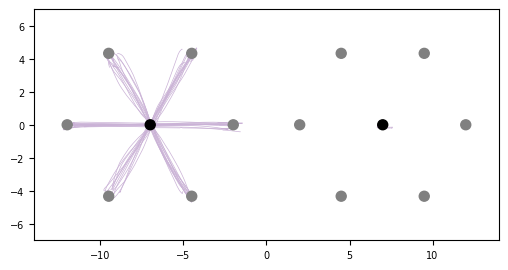

left hand: 0.186% +- 0.026315 SEM


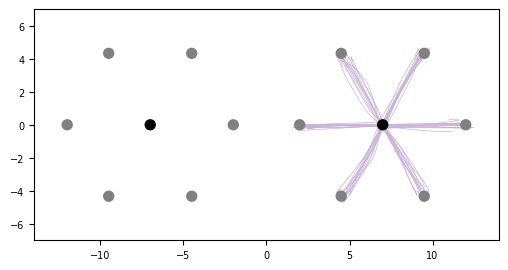

In [74]:
df = pd.read_pickle(os.path.join(anaDir, 'avg_traj.pkl'))
left_conds = ['left_0', 'left_60', 'left_120', 'left_180', 'left_240', 'left_300']
# select 6 colors:
# colors = [cm.Paired(2),cm.Paired(2),cm.Paired(9),cm.Paired(9),cm.Paired(9),cm.Paired(2)]
colors = [cm.Paired(8),cm.Paired(8),cm.Paired(8),cm.Paired(8),cm.Paired(8),cm.Paired(8)]
fix, ax = plt.subplots(figsize=(6, 3))
unintended_range = np.zeros(12)
intended_range = np.zeros(12)
for cond in left_conds:
    df_uni = df[(df.cond==cond)].reset_index()
    for i, row in df_uni.iterrows():
        # plot unimanual trajectories:
        plt.plot(row['avg_x_l'], row['avg_y_l'], color=colors[left_conds.index(cond)], alpha=1, lw=0.5)
        plt.plot(row['avg_x_r'], row['avg_y_r'], color=colors[left_conds.index(cond)], alpha=1, lw=0.5)
    
        # unintended hand is the right hand, find its range of movement:
        x_range = np.max(row['avg_x_r']) - np.min(row['avg_x_r'])
        y_range = np.max(row['avg_y_r']) - np.min(row['avg_y_r'])
        unintended_range[i] += np.sqrt(x_range**2 + y_range**2) / len(right_conds)

        x_range = np.max(row['avg_x_l']) - np.min(row['avg_x_l'])
        y_range = np.max(row['avg_y_l']) - np.min(row['avg_y_l'])
        intended_range[i] += np.sqrt(x_range**2 + y_range**2) / len(right_conds)

percent_unintended = 100 * unintended_range / intended_range
print(f'right hand: {np.mean(percent_unintended):.3f}% +- {np.std(percent_unintended)/np.sqrt(len(percent_unintended)):.6f} SEM')

utils.please.draw_board(ax=ax, radius=5, zorder=999)
ax.set_xlim(-14, 14)
ax.set_ylim(-7, 7)
# save figure:
plt.savefig(os.path.join(figDir, 'reach_trajectories', f'left_hand_unintended_movements.pdf'), bbox_inches="tight")
plt.show()

right_conds = ['right_0', 'right_60', 'right_120', 'right_180', 'right_240', 'right_300']
colors = [cm.Paired(8),cm.Paired(8),cm.Paired(8),cm.Paired(8),cm.Paired(8),cm.Paired(8)]
fix, ax = plt.subplots(figsize=(6, 3))
unintended_range = np.zeros(12)
intended_range = np.zeros(12)
for cond in right_conds:
    df_uni = df[(df.cond==cond)].reset_index()
    
    for i, row in df_uni.iterrows():
        # plot unimanual trajectories:
        plt.plot(row['avg_x_l'], row['avg_y_l'], color=colors[right_conds.index(cond)], alpha=1, lw=0.5)
        plt.plot(row['avg_x_r'], row['avg_y_r'], color=colors[right_conds.index(cond)], alpha=1, lw=0.5)

        # unintended hand is the left hand, find its range of movement:
        x_range = np.max(row['avg_x_l']) - np.min(row['avg_x_l'])
        y_range = np.max(row['avg_y_l']) - np.min(row['avg_y_l'])
        unintended_range[i] += np.sqrt(x_range**2 + y_range**2) / len(right_conds)

        x_range = np.max(row['avg_x_r']) - np.min(row['avg_x_r'])
        y_range = np.max(row['avg_y_r']) - np.min(row['avg_y_r'])
        intended_range[i] += np.sqrt(x_range**2 + y_range**2) / len(right_conds)

percent_unintended = 100 * unintended_range / intended_range
print(f'left hand: {np.mean(percent_unintended):.3f}% +- {np.std(percent_unintended)/np.sqrt(len(percent_unintended)):.6f} SEM')

utils.please.draw_board(ax=ax, radius=5, zorder=999)
ax.set_xlim(-14, 14)
ax.set_ylim(-7, 7)
# save figure:
plt.savefig(os.path.join(figDir, 'reach_trajectories', f'right_hand_unintended_movements.pdf'), bbox_inches="tight")
plt.show()




# Cosine similarity unintended hand movement direction

In [63]:
df = pd.read_pickle(os.path.join(anaDir, 'avg_traj.pkl'))
uni_conds = ['left_0', 'left_60', 'left_120', 'left_180', 'left_240', 'left_300',
             'right_0', 'right_60', 'right_120', 'right_180', 'right_240', 'right_300']
target_angles = {'0': np.array([1, 0]), 
                 '60': np.array([0.5, np.sqrt(3)/2]), 
                 '120': np.array([-0.5, np.sqrt(3)/2]), 
                 '180': np.array([-1, 0]), 
                 '240': np.array([-0.5, -np.sqrt(3)/2]), 
                 '300': np.array([0.5, -np.sqrt(3)/2])}
dur_after_gocue = 500 # in ms

df_cos = {'sn': [], 'cond': [], 'hand': [], 'cosine': [], 'angle_diff': [], 'is_intended': []}

# colors = [cm.Paired(2),cm.Paired(2),cm.Paired(9),cm.Paired(9),cm.Paired(9),cm.Paired(2)]
colors = [cm.Paired(8),cm.Paired(8),cm.Paired(8),cm.Paired(8),cm.Paired(8),cm.Paired(8)]
for cond in uni_conds:
    df_uni = df[(df.cond==cond)]
    unintended_range = 0
    intended_range = 0
    for i, row in df_uni.iterrows():
        x_l = row['avg_x_l']
        y_l = row['avg_y_l']
        x_r = row['avg_x_r']
        y_r = row['avg_y_r']

        target_vector = target_angles[cond.split('_')[1]]
        movement_vector_l = np.array([np.mean(x_l[1:dur_after_gocue//5] - x_l[0]), np.mean(y_l[1:dur_after_gocue//5]) - y_l[0]])
        movement_vector_r = np.array([np.mean(x_r[1:dur_after_gocue//5] - x_r[0]), np.mean(y_r[1:dur_after_gocue//5]) - y_r[0]])
        
        cosine_l = np.dot(target_vector, movement_vector_l) / (np.linalg.norm(target_vector) * np.linalg.norm(movement_vector_l) + 1e-10)
        cosine_r = np.dot(target_vector, movement_vector_r) / (np.linalg.norm(target_vector) * np.linalg.norm(movement_vector_r) + 1e-10)

        # angle diff:
        target_angle = int(cond.split('_')[1])

        dx_l = np.mean(x_l[1:dur_after_gocue//5]) - x_l[0]
        dy_l = np.mean(y_l[1:dur_after_gocue//5]) - y_l[0]
        angle_l = np.rad2deg(np.arctan2(dy_l, dx_l))
        angle_diff_l = angle_l - target_angle
        # adjust angle diff to be within -180 to 180
        if angle_diff_l > 180:
            angle_diff_l -= 360
        elif angle_diff_l < -180:
            angle_diff_l += 360
        
        dx_r = np.mean(x_r[1:dur_after_gocue//5]) - x_r[0]
        dy_r = np.mean(y_r[1:dur_after_gocue//5]) - y_r[0]
        angle_r = np.rad2deg(np.arctan2(dy_r, dx_r))
        angle_diff_r = angle_r - target_angle
        # adjust angle diff to be within -180 to 180
        if angle_diff_r > 180:
            angle_diff_r -= 360
        elif angle_diff_r < -180:
            angle_diff_r += 360

        df_cos['sn'].append(row['sn'])
        df_cos['cond'].append(cond)
        df_cos['hand'].append('left')
        df_cos['cosine'].append(cosine_l)
        df_cos['angle_diff'].append(angle_diff_l)
        df_cos['is_intended'].append((1 if 'left' in cond else 0))
        df_cos['sn'].append(row['sn'])
        df_cos['cond'].append(cond)
        df_cos['hand'].append('right')
        df_cos['cosine'].append(cosine_r)
        df_cos['angle_diff'].append(angle_diff_r)
        df_cos['is_intended'].append((1 if 'right' in cond else 0))

df_cos = pd.DataFrame(df_cos)



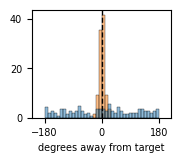

In [ ]:
# dist plot:
plt.figure(figsize=(1.8,1.4))
sns.histplot(data=df_cos, x='angle_diff', hue='is_intended', stat='percent', common_norm=False, legend=False)
plt.axvline(0, color='black', linestyle='--', lw=1, zorder=1)
plt.ylabel('')
plt.xticks([-180, 0, 180])
plt.yticks([0,20,40])
plt.xlim([-220, 220])
plt.xlabel('degrees away from target')
plt.savefig(os.path.join(figDir, 'reach_trajectories', f'instructed_vs_uninstructed.pdf'), bbox_inches="tight")
plt.show()



# single-trial angle deviation from target

In [3]:
sn_list = [101, 104, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115]
D = pd.read_csv(os.path.join(anaDir, f's{101}_scan.csv'))

uni_conds = ['left_0', 'left_60', 'left_120', 'left_180', 'left_240', 'left_300',
             'right_0', 'right_60', 'right_120', 'right_180', 'right_240', 'right_300']
target_angles = {'0': np.array([1, 0]), 
                 '60': np.array([0.5, np.sqrt(3)/2]), 
                 '120': np.array([-0.5, np.sqrt(3)/2]), 
                 '180': np.array([-1, 0]), 
                 '240': np.array([-0.5, -np.sqrt(3)/2]), 
                 '300': np.array([0.5, -np.sqrt(3)/2])}

df = {'sn': [], 'cond': [], 'hand':[], 'is_instructed': [], 'range':[], 'angle':[], 'BN': [], 'TN': []}
for sn in sn_list:
    D = pd.read_csv(os.path.join(anaDir, f's{sn}_scan.csv'))
    D = D[D.GoodMovement == 1]
    D_mov = pd.read_csv(os.path.join(anaDir, f's{sn}_scan_mov.csv'))
    for cond in uni_conds:
        BNs = D.BN[D.cond_name==cond].values.flatten()
        TNs = D.TN[D.cond_name==cond].values.flatten()
        
        # loop over trials of the subject:
        n_trials = len(BNs)
        for i in range(len(BNs)):
            BN = BNs[i]
            TN = TNs[i]
            idx_gocue = D.idx_gocue[(D.BN==BN) & (D.TN==TN)].values[0]
            idx_endReach = D.idx_endReach[(D.BN==BN) & (D.TN==TN)].values[0]

            t1 = idx_gocue
            t2 = idx_endReach

            # kinematic traces:
            trial_mov = D_mov[(D_mov.BN==BN) & (D_mov.TN==TN)]
            radius_l = trial_mov['mov_5'].values.flatten()[t1:t2]
            radius_r = trial_mov['mov_6'].values.flatten()[t1:t2]
            angle_l = trial_mov['mov_7'].values.flatten()[t1:t2]
            angle_r = trial_mov['mov_8'].values.flatten()[t1:t2]
            
            radius = 5
            x_offset = radius + 2
            y_offset = 0
            x_l = radius_l * np.cos(np.deg2rad(angle_l)) - x_offset
            y_l = radius_l * np.sin(np.deg2rad(angle_l)) + y_offset
            x_r = radius_r * np.cos(np.deg2rad(angle_r)) + x_offset
            y_r = radius_r * np.sin(np.deg2rad(angle_r)) + y_offset

            # which is the uninstructed hand?
            if 'left' in cond:
                x_un = x_r
                y_un = y_r
                x_in = x_l
                y_in = y_l
            else:
                x_un = x_l
                y_un = y_l
                x_in = x_r
                y_in = y_r
            
            # find the index of the maximum distance of unintended hand from the start position:
            start_x_un = x_un[0]
            start_y_un = y_un[0]
            dists_un = np.sqrt((x_un - start_x_un)**2 + (y_un - start_y_un)**2)
            max_dist_un = np.max(dists_un) # max range of unintended hand
            idx_maxrange_un = np.argmax(dists_un) # index of max range

            start_x_in = x_in[0]
            start_y_in = y_in[0]
            dists_in = np.sqrt((x_in - start_x_in)**2 + (y_in - start_y_in)**2)
            max_dist_in = np.max(dists_in) # max range of instructed hand
            idx_maxrange_in = np.argmax(dists_in) # index of max range
            # max_dist_in = np.sqrt((x_in[-1] - x_in[0])**2 + (y_in[-1] - y_in[0])**2) # range from go-cue to end of reach

            # angle of both hands at max range:
            dx_un = x_un[idx_maxrange_un] - start_x_un
            dy_un = y_un[idx_maxrange_un] - start_y_un
            angle_un = np.rad2deg(np.arctan2(dy_un, dx_un))

            dx_in = x_in[idx_maxrange_in] - start_x_in
            dy_in = y_in[idx_maxrange_in] - start_y_in
            angle_in = np.rad2deg(np.arctan2(dy_in, dx_in))

            # find the angle difference from target:
            target_angle = int(cond.split('_')[1])
            angle_diff_un = angle_un - target_angle
            angle_diff_in = angle_in - target_angle
            # adjust angle diff to be within -180 to 180
            if angle_diff_un > 180:
                angle_diff_un -= 360
            elif angle_diff_un < -180:
                angle_diff_un += 360
            if angle_diff_in > 180:
                angle_diff_in -= 360
            elif angle_diff_in < -180:
                angle_diff_in += 360

            # store the uninstructed hand movement data:
            df['sn'].append(sn)
            df['cond'].append(cond)
            df['hand'].append('right' if 'left' in cond else 'left')
            df['is_instructed'].append(0)
            df['range'].append(max_dist_un)
            df['angle'].append(angle_diff_un)
            df['BN'].append(BN)
            df['TN'].append(TN)

            # store the instructed hand movement data:
            df['sn'].append(sn)
            df['cond'].append(cond)
            df['hand'].append('left' if 'left' in cond else 'right')
            df['is_instructed'].append(1)
            df['range'].append(max_dist_in)
            df['angle'].append(angle_diff_in)
            df['BN'].append(BN)
            df['TN'].append(TN)

df = pd.DataFrame(df)
df.to_pickle(os.path.join(anaDir, 'uninstructed_hand_movements.pkl'))



plot

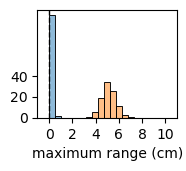

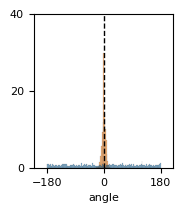

avg unintstructed = 0.021 cm +- 0.008 SEM
avg instructed = 3.588 cm +- 0.032 SEM

Relative uninstructed/instructed avg: 0.604% +- 0.236 SEM
t-test left vs right uninstructed ranges: t(11)=-1.331, p=0.210


In [4]:
# plot the distribution of uninstructed hand movement ranges:
df = pd.read_pickle(os.path.join(anaDir, 'uninstructed_hand_movements.pkl'))
plt.figure(figsize=(1.8,1.4))
sns.histplot(data=df, x='range', hue='is_instructed', stat='percent', common_norm=False, legend=False)
plt.axvline(0, color='black', linestyle='--', lw=1, zorder=1)
plt.ylabel('')
plt.xticks([0,2,4,6,8,10])
plt.yticks([0,20,40])
plt.xlim([-1, 11])
plt.xlabel('maximum range (cm)')
plt.savefig(os.path.join(figDir, 'reach_trajectories', f'uninstructed_hand_movement_ranges.pdf'), bbox_inches="tight")
plt.show()

# plot the distribution of uninstructed hand movement angles:
plt.rcParams.update({'font.size': 8})
plt.figure(figsize=(1.8,2))
sns.histplot(data=df, x='angle', hue='is_instructed', stat='percent', common_norm=False, legend=False)
plt.axvline(0, color='black', linestyle='--', lw=1, zorder=1)
plt.ylabel('')
plt.xticks([-180, 0, 180])
plt.yticks([0,20,40])
plt.xlim([-220, 220])
# plt.xlabel('degrees away from target')
plt.savefig(os.path.join(figDir, 'reach_trajectories', f'uninstructed_hand_movement_angles.pdf'), bbox_inches="tight")
plt.show()

# print the relative range of uninstructed hand movements to instructed hand movements separate for left and right hands:
# average the trials:
df_grouped = df.groupby(['sn', 'hand', 'is_instructed']).agg({'range': 'mean'}).reset_index()

left_un = df_grouped[(df_grouped.is_instructed==0) & (df_grouped.hand=='left')]['range'].values
left_in = df_grouped[(df_grouped.is_instructed==1) & (df_grouped.hand=='left')]['range'].values
right_un = df_grouped[(df_grouped.is_instructed==0) & (df_grouped.hand=='right')]['range'].values
right_in = df_grouped[(df_grouped.is_instructed==1) & (df_grouped.hand=='right')]['range'].values
avg_un = (left_un + right_un) / 2
avg_in = (left_in + right_in) / 2
print(f'avg unintstructed = {np.mean(avg_un*3.5/5):.3f} cm +- {np.std(avg_un*3.5/5)/np.sqrt(len(avg_un)):.3f} SEM')
print(f'avg instructed = {np.mean(avg_in*3.5/5):.3f} cm +- {np.std(avg_in*3.5/5)/np.sqrt(len(avg_in)):.3f} SEM\n')

# print(f'Uninstructed left hand movement range: {np.mean(left_un):.3f} cm')
# print(f'Instructed left hand movement range: {np.mean(left_in):.3f} cm')
# print(f'Uninstructed right hand movement range: {np.mean(right_un):.3f} cm')
# print(f'Instructed right hand movement range: {np.mean(right_in):.3f} cm')

# relative ranges:
rel_range_left = 100 * left_un / left_in
rel_range_right = 100 * right_un / right_in
rel_avg = rel_range_left/2 + rel_range_right/2
# print(f'Relative uninstructed left: {np.mean(rel_range_left):.3f}% +- {np.std(rel_range_left)/np.sqrt(len(rel_range_left)):.3f} SEM')
# print(f'Relative uninstructed right: {np.mean(rel_range_right):.3f}% +- {np.std(rel_range_right)/np.sqrt(len(rel_range_right)):.3f} SEM')
print(f'Relative uninstructed/instructed avg: {np.mean(rel_avg):.3f}% +- {np.std(rel_avg)/np.sqrt(len(rel_avg)):.3f} SEM')

# t-test between left and right uninstructed ranges:
ttest_rel = stats.ttest_rel(rel_range_left, rel_range_right, alternative='two-sided')
print(f't-test left vs right uninstructed ranges: t({len(rel_range_left)-1})={ttest_rel.statistic:.3f}, p={ttest_rel.pvalue:.3f}')


